<a href="https://colab.research.google.com/github/ViniciusTavaresSousa/Deteccao-de-Anomalias-Visuais-com-Autoencoder-Convolucional-e-SSIM-no-Dataset-MVTec-AD/blob/main/Autoencoder_MVTecAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

#**Google Drive**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#**Configurações**

In [87]:
input_shape = (256, 256, 1)
latent_size = 128
batch_size = 8
epochs = 500

In [88]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#**Base de Dados**

In [89]:
imagens_treinamento = np.load("/content/drive/MyDrive/Autoencoder_MVTecAD/bottle_dataset.npy")
imagens_treinamento = imagens_treinamento.astype('float32')
imagens_treinamento = imagens_treinamento / 255.0

In [90]:
imagens_treinamento.shape

(209, 256, 256, 1)

#**Modelo**

##**Encoder**

In [91]:
def criaEncoder():
    entrada = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same')(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    saida = layers.Dense(latent_size)(x)

    modelo = tf.keras.Model(entrada, saida, name="Encoder")
    modelo.summary()

    return modelo

In [92]:
encoder = criaEncoder()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,194,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,464,832 (17.03 MB)

 Trainable params: 4,464,352 (17.03 MB)

 Non-trainable params: 480 (1.88 KB)

##**Decoder**

In [93]:
def criaDecoder():
    entrada = tf.keras.Input(shape=(latent_size,))

    x = layers.Dense(16 * 16 * 128)(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Reshape((16, 16, 128))(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2DTranspose(32, (5, 5), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2DTranspose(16, (5, 5), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    saida = layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same', activation='sigmoid')(x)

    modelo = tf.keras.Model(entrada, saida, name="Decoder")
    modelo.summary()
    return modelo


In [94]:
decoder = criaDecoder()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 32, 32, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 64, 64, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 128, 128, 16)   │        12,816 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 256, 256, 1)    │           145 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,627,649 (17.65 MB)

 Trainable params: 4,561,889 (17.40 MB)

 Non-trainable params: 65,760 (256.88 KB)

##**Autoencoder**

In [95]:
autoencoder = tf.keras.Model(encoder.input, decoder(encoder.output), name="Autoencoder")
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 256, 256, 1)    │     4,627,649 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,092,481 (34.69 MB)

 Trainable params: 9,026,241 (34.43 MB)

 Non-trainable params: 66,240 (258.75 KB)

##**Perda**

In [96]:
def perda(y_true, y_pred):

    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    perda_ssim = 1 - ssim

    return 0.5 * mse + 0.5 * perda_ssim

##**Treinamento**

In [97]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=perda)

autoencoder.fit(imagens_treinamento, imagens_treinamento, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.5447 - val_loss: 0.3477
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4089 - val_loss: 0.3536
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3405 - val_loss: 0.3226
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3022 - val_loss: 0.3026
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2776 - val_loss: 0.2833
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2584 - val_loss: 0.3542
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2397 - val_loss: 0.4326
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2215 - val_loss: 0.4538
Epoch 9/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2071 - val_loss: 0.4950
Epoch 10/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1964 - val_loss: 0.4541
Epoch 11/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1876 - val_loss: 0.4022
Epoch 12/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

In [98]:
autoencoder.save("/content/drive/MyDrive/Autoencoder_MVTecAD/autoencoder.keras")

##**Resultados**

In [99]:
autoencoder = tf.keras.models.load_model("/content/drive/MyDrive/Autoencoder_MVTecAD/autoencoder.keras", custom_objects={"perda": perda})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


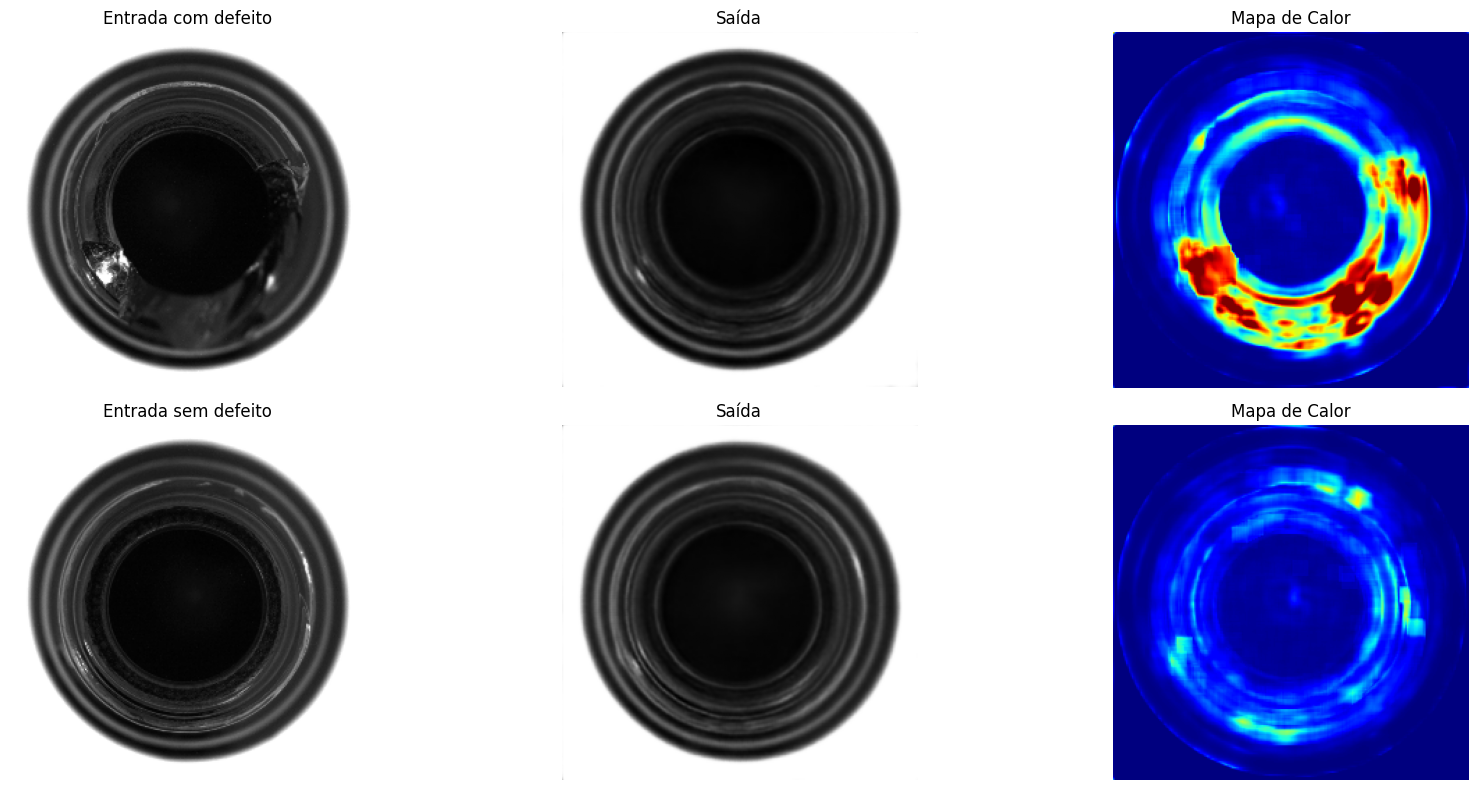

In [101]:
def carregar_imagens(pasta):
    imagens = []
    for nome_arquivo in os.listdir(pasta):
        if nome_arquivo.lower().endswith(('.png')):
            caminho = os.path.join(pasta, nome_arquivo)
            img = cv2.imread(caminho)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_gray = cv2.resize(img_gray, (256, 256))
            img_gray = img_gray.astype(np.float32) / 255.0
            imagens.append(img_gray)
    imagens_array = np.array(imagens, dtype=np.float32)[..., np.newaxis]
    return imagens_array

def ssim_map(img1, img2):

    img1 = tf.expand_dims(img1, axis=0)
    img2 = tf.expand_dims(img2, axis=0)

    patches1 = tf.image.extract_patches(images=img1,
                                        sizes=[1,11,11,1],
                                        strides=[1,1,1,1],
                                        rates=[1,1,1,1],
                                        padding='VALID')
    patches2 = tf.image.extract_patches(images=img2,
                                        sizes=[1,11,11,1],
                                        strides=[1,1,1,1],
                                        rates=[1,1,1,1],
                                        padding='VALID')

    patches1 = tf.reshape(patches1, [-1, 11*11])
    patches2 = tf.reshape(patches2, [-1, 11*11])

    def mean(x):
        return tf.reduce_mean(x, axis=1, keepdims=True)

    mu1 = mean(patches1)
    mu2 = mean(patches2)

    sigma1 = tf.math.reduce_variance(patches1, axis=1, keepdims=True)
    sigma2 = tf.math.reduce_variance(patches2, axis=1, keepdims=True)

    sigma12 = tf.reduce_mean((patches1 - mu1) * (patches2 - mu2), axis=1, keepdims=True)

    c1 = 0.01**2
    c2 = 0.03**2

    ssim_n = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)
    ssim_d = (mu1**2 + mu2**2 + c1) * (sigma1 + sigma2 + c2)
    ssim_val = ssim_n / ssim_d

    ssim_map = tf.reshape(ssim_val, [img1.shape[1]-10, img1.shape[2]-10])

    return ssim_map.numpy()

def comparar_imagens(modelo, img_defeito, img_boa):

    modelo_predict = lambda img: modelo.predict(img[np.newaxis, ...])[0]

    recon_defeito = modelo_predict(img_defeito)
    recon_boa = modelo_predict(img_boa)

    ssim_defeito = ssim_map(tf.convert_to_tensor(img_defeito, dtype=tf.float32),
                           tf.convert_to_tensor(recon_defeito, dtype=tf.float32))
    ssim_boa = ssim_map(tf.convert_to_tensor(img_boa, dtype=tf.float32),
                        tf.convert_to_tensor(recon_boa, dtype=tf.float32))

    erro_defeito = 1 - ssim_defeito
    erro_boa = 1 - ssim_boa

    plt.figure(figsize=(18, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(img_defeito.squeeze(), cmap='gray')
    plt.title("Entrada com defeito")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(recon_defeito, cmap='gray')
    plt.title("Saída")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(erro_defeito, cmap='jet', vmin=0, vmax=1)
    plt.title("Mapa de Calor")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(img_boa.squeeze(), cmap='gray')
    plt.title("Entrada sem defeito")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(recon_boa, cmap='gray')
    plt.title("Saída")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(erro_boa, cmap='jet', vmin=0, vmax=1)
    plt.title("Mapa de Calor")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

pasta_defeito = "/content/drive/MyDrive/Autoencoder_MVTecAD/mvtec/bottle/test/broken_large"
pasta_boa = "/content/drive/MyDrive/Autoencoder_MVTecAD/mvtec/bottle/test/good"

imgs_defeito = carregar_imagens(pasta_defeito)
imgs_boa = carregar_imagens(pasta_boa)

indice = 0

img_defeito = imgs_defeito[indice]
img_boa = imgs_boa[indice]

comparar_imagens(autoencoder, img_defeito, img_boa)